# Loading data for modelling <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup---making-example-data" data-toc-modified-id="Setup---making-example-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup - making example data</a></span></li><li><span><a href="#Compressed-data-formats" data-toc-modified-id="Compressed-data-formats-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compressed data formats</a></span><ul class="toc-item"><li><span><a href="#Piano-roll" data-toc-modified-id="Piano-roll-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Piano roll</a></span></li><li><span><a href="#Command" data-toc-modified-id="Command-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Command</a></span></li><li><span><a href="#location-within-the-dataset" data-toc-modified-id="location-within-the-dataset-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>location within the dataset</a></span></li></ul></li><li><span><a href="#Dataset-classes" data-toc-modified-id="Dataset-classes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset classes</a></span><ul class="toc-item"><li><span><a href="#PianorollDataset" data-toc-modified-id="PianorollDataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>PianorollDataset</a></span></li><li><span><a href="#CommandDataset" data-toc-modified-id="CommandDataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CommandDataset</a></span></li></ul></li><li><span><a href="#The-Degrader()-class" data-toc-modified-id="The-Degrader()-class-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The <code>Degrader()</code> class</a></span></li></ul></div>

In this notebook we introduce:
* the compressed data formats created by the `make_dataset.py` script,
* the different dataset classes included in the package for loading data to models, and
* the `Degrader()` class for degrading data on the fly

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from IPython.display import Audio, display
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import mdtk.degradations as degs
from mdtk.degrader import Degrader
from mdtk.formatters import (
    CommandVocab,
    df_to_pianoroll_str,
    pianoroll_str_to_df,
    df_to_command_str,
    command_str_to_df,
)
from mdtk.pytorch_datasets import (
    PianorollDataset,
    CommandDataset,
    
)
from utils import plot_against_orig, plot_from_df, synthesize_from_note_df

# Setup - making example data

First we generate a small acme dataset as an example.

In [3]:
! python ../make_dataset.py --datasets PianoMidi --no-prompt --seed 42

Setting random seed to 42.
Loading data from downloaders, this could take a while...
Copying midi to /home/andrew/.mdtk_cache/PianoMidi/data: 100%|█| 328/328 [00:00<
Creating pianoroll corpus: 100%|██████████████| 328/328 [00:11<00:00, 29.21it/s]

========== Finished! ==========

Count of degradations:
	* none: 36
	* pitch_shift: 37
	* time_shift: 37
	* onset_shift: 36
	* offset_shift: 36
	* remove_note: 37
	* add_note: 36
	* split_note: 37
	* join_notes: 36

You will find the generated data at /mnt/c/Users/apmcl/Documents/GitHub/midi_degradation_toolkit/docs/acme with subdirectories
	* clean - contains the extracted clean excerpts
	* altered - contains the excerpts altered by the degradations described in metadata.csv

metadata.csv describes:
	* (the id number for) the type of degradation used for the alteration
	* the path for the altered and clean files
	* which split (train, valid, test) the file should be used in
	* in which corpus and on what line the file is located

degradation

We also make a small example for easy visualization:

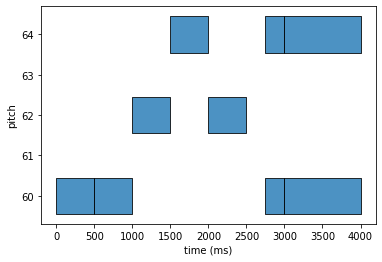

In [4]:
pitches = [60, 60, 62, 64, 62, 60, 64, 60, 64]
bpm = 120
beat_dur = 60/bpm * 1000
durations = [1, 1, 1, 1, 1, .5, .5, 2, 2]
durations = [int(beats*beat_dur) for beats in durations]
onsets = [0, 1, 2, 3, 4, 5.5, 5.5, 6, 6]
onsets = [int(beats*beat_dur) for beats in onsets]
velocities = [pitch + 20 for pitch in pitches]
excerpt = pd.DataFrame(
    {
        "onset": onsets,
        "track": 0,
        "pitch": pitches,
        "dur": durations,
        "velocity": velocities,
    }
)
plot_from_df(excerpt)

In [5]:
Audio(synthesize_from_note_df(excerpt), rate=16000)

# Compressed data formats

The package contains functions for converting the pandas note dataframes into string for easy storage and reading.
- `velocity` is not saved, and will be set to 100 upon converting back into a note dataframe.
- `track` is not saved, and will be set to 0 upon converting back into a note dataframe.

## Piano roll

A piano roll is stored as a string. Each time slice is delimited by a forward slash `/`. Each time slice indicates if a pitch is sounding, and if this is when the note onset occurred. For example, using the excerpt created in the setup, and choosing to create frames of length 250ms:

In [6]:
pianoroll_str = df_to_pianoroll_str(excerpt, time_increment=250)
pianoroll_str

'60_60/60_/60_60/60_/62_62/62_/64_64/64_/62_62/62_/_/60 64_60 64/60 64_60 64/60 64_/60 64_/60 64_'

In [7]:
frames = pianoroll_str.split("/")
frames

['60_60',
 '60_',
 '60_60',
 '60_',
 '62_62',
 '62_',
 '64_64',
 '64_',
 '62_62',
 '62_',
 '_',
 '60 64_60 64',
 '60 64_60 64',
 '60 64_',
 '60 64_',
 '60 64_']

In [8]:
sounding, note_on = zip(*[frame.split("_") for frame in frames])

In [9]:
sounding

('60',
 '60',
 '60',
 '60',
 '62',
 '62',
 '64',
 '64',
 '62',
 '62',
 '',
 '60 64',
 '60 64',
 '60 64',
 '60 64',
 '60 64')

In [10]:
note_on

('60',
 '',
 '60',
 '',
 '62',
 '',
 '64',
 '',
 '62',
 '',
 '',
 '60 64',
 '60 64',
 '',
 '',
 '')

If there are multiple notes sounding, or beginning, in a given frame, these are space delimited.

A function is included to invert the operation

In [11]:
pianoroll_str_to_df(pianoroll_str, time_increment=250)

,onset,track,pitch,dur,velocity
0,0,0,60,500,100
1,500,0,60,500,100
2,1000,0,62,500,100
3,1500,0,64,500,100
4,2000,0,62,500,100
5,2750,0,60,250,100
6,2750,0,64,250,100
7,3000,0,60,1000,100
8,3000,0,64,1000,100


## Command

This is a sequence of space delimited, midi like commands:
* `o` indicates a pitch is coming on
* `f` indicates a pitch is ending
* `t` indicates the current time is shifting forward

In [12]:
command_str = df_to_command_str(excerpt, time_increment=250)
command_str

'o60 t500 f60 o60 t500 f60 o62 t500 f62 o64 t500 f64 o62 t500 f62 t250 o60 o64 t250 f60 f64 o60 o64 t1000 f60 f64'

In [13]:
command_str_to_df(command_str)

,onset,track,pitch,dur,velocity
0,0,0,60,500,100
1,500,0,60,500,100
2,1000,0,62,500,100
3,1500,0,64,500,100
4,2000,0,62,500,100
5,2750,0,60,250,100
6,2750,0,64,250,100
7,3000,0,60,1000,100
8,3000,0,64,1000,100


## location within the dataset

The generated dataset's metadata indicates the location of each of the excerpts within each format corpus.

In [14]:
degradation_ids = pd.read_csv(Path('acme', 'degradation_ids.csv'))
metadata = pd.read_csv(Path('acme', 'metadata.csv'))
metadata.head(10)

,altered_csv_path,degraded,degradation_id,clean_csv_path,split,cmd_corpus_path,cmd_corpus_line_nr,pr_corpus_path,pr_corpus_line_nr
0,altered/PianoMidi/mz_332_2.csv,1,2,clean/PianoMidi/mz_332_2.csv,train,train_cmd_corpus.csv,0,train_pr_corpus.csv,0
1,altered/PianoMidi/clementi_opus36_1_2.csv,1,7,clean/PianoMidi/clementi_opus36_1_2.csv,valid,valid_cmd_corpus.csv,0,valid_pr_corpus.csv,0
2,altered/PianoMidi/rac_op32_13.csv,1,5,clean/PianoMidi/rac_op32_13.csv,train,train_cmd_corpus.csv,1,train_pr_corpus.csv,1
3,altered/PianoMidi/alb_se4.csv,1,1,clean/PianoMidi/alb_se4.csv,train,train_cmd_corpus.csv,2,train_pr_corpus.csv,2
4,altered/PianoMidi/chpn_op25_e12.csv,1,3,clean/PianoMidi/chpn_op25_e12.csv,test,test_cmd_corpus.csv,0,test_pr_corpus.csv,0
5,altered/PianoMidi/muss_8.csv,1,4,clean/PianoMidi/muss_8.csv,train,train_cmd_corpus.csv,3,train_pr_corpus.csv,3
6,clean/PianoMidi/scn16_7.csv,0,0,clean/PianoMidi/scn16_7.csv,train,train_cmd_corpus.csv,4,train_pr_corpus.csv,4
7,altered/PianoMidi/mendel_op19_6.csv,1,8,clean/PianoMidi/mendel_op19_6.csv,train,train_cmd_corpus.csv,5,train_pr_corpus.csv,5
8,altered/PianoMidi/mendel_op30_5.csv,1,6,clean/PianoMidi/mendel_op30_5.csv,train,train_cmd_corpus.csv,6,train_pr_corpus.csv,6
9,altered/PianoMidi/chpn_op35_1.csv,1,2,clean/PianoMidi/chpn_op35_1.csv,train,train_cmd_corpus.csv,7,train_pr_corpus.csv,7


For example, the an excerpt is located as follows:

In [15]:
filename, line_nr = metadata.loc[0, ["cmd_corpus_path", "cmd_corpus_line_nr"]]

In [16]:
with open(Path('acme', filename), 'r') as fh:
    corpus_lines = [line.strip() for line in fh.readlines()]

In [17]:
corpus_lines[line_nr]

'o52 o67 t120 f67 t80 o67 t80 f67 o69 t120 f52 f69 o58 o67 t120 f67 o65 t160 f65 o67 t120 f58 f67 o53 o65 t440 o60 t400 f60 f65 o65 t280 o77 t120 f65 f77 o63 o77 t80 f77 o79 t80 f79 o77 t80 f77 o76 t80 f76 o77 t80 f63 f77 o62 o84 t400 f84 o82 t400 f62 f82 o60 o81 t400 f81 o79 t400 f53 f60 f79 o53 o57 o79 t40 o69 t80 f69 t280 f57 f79 o60 o77 t440 f60 f77 o65 t400 f65 t2000 f53,o52 o67 t120 f67 o69 t80 f69 o67 t80 f67 o69 t120 f52 f69 o58 o67 t120 f67 o65 t160 f65 o67 t120 f58 f67 o53 o65 t440 o60 t400 f60 f65 o65 t280 o77 t120 f65 f77 o63 o77 t80 f77 o79 t80 f79 o77 t80 f77 o76 t80 f76 o77 t80 f63 f77 o62 o84 t400 f84 o82 t400 f62 f82 o60 o81 t400 f81 o79 t400 f53 f60 f79 o53 o57 o79 t400 f57 f79 o60 o77 t440 f60 f77 o65 t400 f65 t2000 f53,2'

the value after the comma is the degradation which has been applied.

In [18]:
degradation_ids.loc[degradation_ids.id==2]

,id,degradation_name
2,2,time_shift


# Dataset classes

For our proposed modelling tasks, we include pytorch dataset classes. These read a corpus of data, like that which the `make_dataset.py` script creates, and returns data items.

## PianorollDataset

In [19]:
dataset = PianorollDataset(
    corpus_path=Path('acme', 'train_pr_corpus.csv'),
    seq_len=256,
)

Loading Dataset: 262it [00:00, 2065.92it/s]


In [20]:
len(dataset)

262

Each data item contains:
* degraded and clean piano roll matrices
* the label of the degradation applied
* a vector indicating in which frames a change was made
* the unpadded length of the degraded and clean pianorolls
    

In [21]:
idx = 42
data_item = dataset[idx]
data_item.keys()

dict_keys(['deg_pr', 'clean_pr', 'deg_label', 'changed_frames', 'deg_len', 'clean_len'])

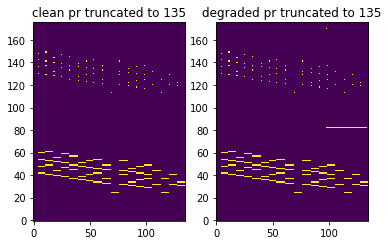

In [22]:
fig, ax = plt.subplots(1, 2)
deg_len = data_item["deg_len"]
plt.imshow(data_item['deg_pr'][:deg_len].T, origin='lower', interpolation="none")
plt.title(f"degraded pr truncated to {deg_len}")
plt.sca(ax[0])
clean_len = data_item["clean_len"]
plt.imshow(data_item['clean_pr'][:deg_len].T, origin='lower', interpolation="none")
plt.title(f"clean pr truncated to {clean_len}");

In [23]:
degradation_ids.loc[degradation_ids.id==data_item['deg_label']]

,id,degradation_name
6,6,add_note


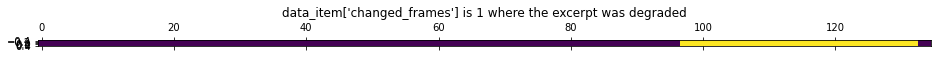

In [24]:
plt.matshow(data_item['changed_frames'][np.newaxis,:deg_len])
plt.title("data_item['changed_frames'] is 1 where the excerpt was degraded");

In [25]:
?PianorollDataset

## CommandDataset

In [26]:
vocab = CommandVocab()
dataset = CommandDataset(
    corpus_path=Path('acme', 'train_cmd_corpus.csv'),
    vocab=vocab,
    seq_len=256,
)

Loading Dataset: 262it [00:00, 4967.94it/s]


In [27]:
len(dataset)

262

Each data item contains:
* degraded and clean command data *which has been tokenized* with the supplied tokenizer
* the label of the degradation applied
* the unpadded length of the degraded and clean command data
    

In [28]:
idx = 42
data_item = dataset[idx]
data_item.keys()

dict_keys(['deg_cmd', 'clean_cmd', 'deg_label', 'deg_len', 'clean_len'])

In [29]:
deg_len = data_item['deg_len']
data_item['deg_cmd'][:5], "...", data_item['deg_cmd'][deg_len-5:deg_len+1], "...", data_item['deg_cmd'][-5:]

([3, 46, 52, 58, 64],
 '...',
 [174, 181, 123, 126, 2, 0],
 '...',
 [0, 0, 0, 0, 0])

In [30]:
(
    [vocab.itos[idx] for idx in data_item['deg_cmd'][:5]],
    "...",
    [vocab.itos[idx] for idx in data_item['deg_cmd'][deg_len-5:deg_len+1]],
    "...",
    [vocab.itos[idx] for idx in data_item['deg_cmd'][-5:]]
)

(['<sos>', 'o63', 'o69', 'o75', 'o81'],
 '...',
 ['f103', 't80', 'f52', 'f55', '<eos>', '<pad>'],
 '...',
 ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>'])

In [31]:
degradation_ids.loc[degradation_ids.id==data_item['deg_label']]

,id,degradation_name
6,6,add_note


In [32]:
?CommandDataset

# The `Degrader()` class

The `Degrader()` class can be used to degrade note dataframes on the fly. It works much like the make_dataset.py script, but degrades input as and when it is provided at the same time as trying to keep the overall distribution of degradation types as specified by the user. For instance, in this example, have a dataset of two excerpts and, for each epoch, degrade examples with the following scheme:
* 1/3 chance not degraded (i.e. degradation index 0, unchanged)
* 2/3 chance degraded, of those 2:1 time_shift to add_note

In [33]:
degradations = ("time_shift", "add_note")
degrader = Degrader(
    seed=42,
    degradations=degradations,
    degradation_dist=(2, 1),
    clean_prop=1/3,
    config=None,
)

In [34]:
excerpt2 = excerpt.copy()
excerpt2.pitch = excerpt2.pitch.values[::-1]
dataset = [excerpt, excerpt2]

epoch 0


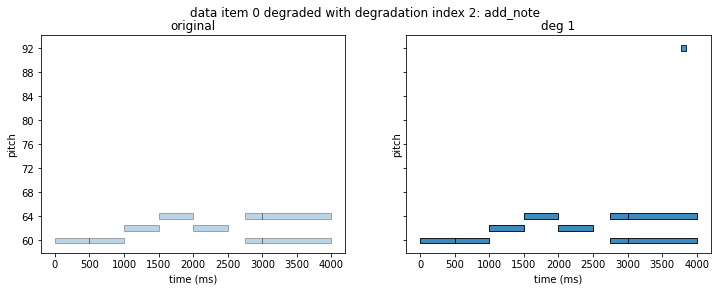

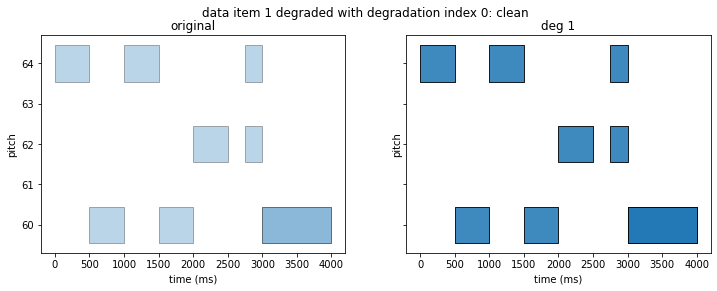

epoch 1


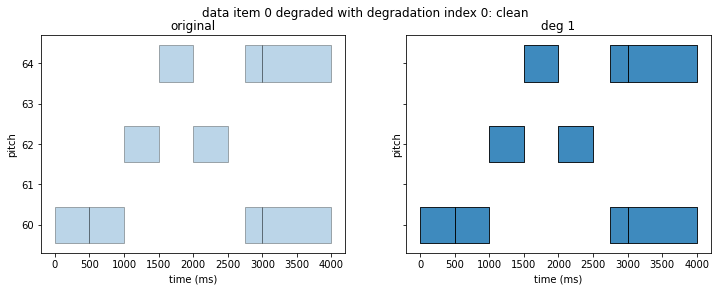

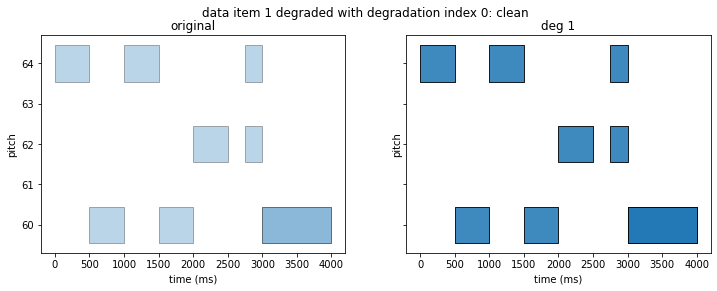

epoch 2


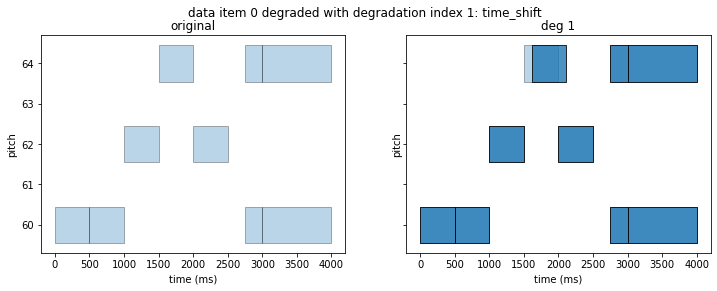

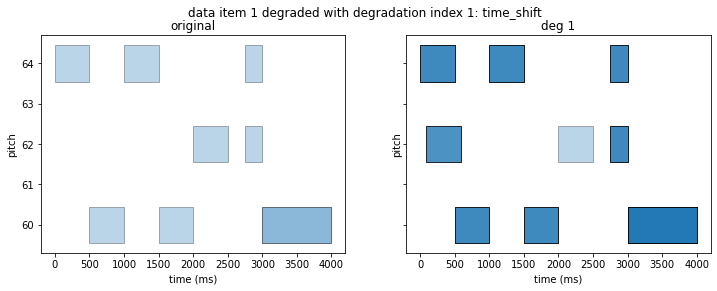

In [35]:
deg_names = ("clean", ) + degradations
for epoch in range(3):
    print(f"epoch {epoch}")
    for ii, data_item in enumerate(dataset):
        deg_df, deg_idx = degrader.degrade(data_item)
        plot_against_orig(data_item, [deg_df])
        plt.suptitle(f"data item {ii} degraded with degradation index {deg_idx}: {deg_names[deg_idx]}")
        plt.show()

In [36]:
?Degrader